# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели, введение в конкурсную задачу


###### <hr\>
**Общая информация**

**Срок сдачи:** 17 апреля 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 апреля, -4 балла после 06:00 24 апреля, -6 баллов после 06:00 1 мая

Имеется ввиду именно сдача данного ДЗ, а не конечного результата по конкурсу (см ниже).<br\>
Жесткий дедлайн по конкурсной задаче - 14 мая 23:59 GMT.

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [168]:
USER_NAME = u"Хапкин".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print ("Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
))

Имплементируйте обучение логистической регрессии с L1 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Считать градиент по мини батчам
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

# Реализация модели

## Имплементация (6 баллов)

In [361]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, k=0.01, max_epoch=10, err = 0.0001):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.w_0 = None
        self.final_coeff = None
        self.C = C
        self.k = k
        self.max_epoch = max_epoch
        self.err = err
    
    def fw(self, j, w, w_0, y, X, k, C):
        l = len(y)
        S = 0
        for i in range(l):
            if y[i] == 1:
                S += y[i] * X[i][j] * (1.0 - 1.0 / (1.0 + math.exp(-y[i] * (sum(w[t]*X[i][t] for t in range(X.shape[1])) + w_0))))
            else:
                S += (1 -y[i]) * X[i][j] /  math.exp(-y[i] * (sum(w[t]*X[i][t] for t in range(X.shape[1])) + w_0))
        return w[j] + (self.k * (1.0 / l) * S) - self.k * self.C * w[j]
    
    
    def f_0(self, w, w_0, y, X, k, C):
        l = len(y)
        S = 0
        for i in range(l):
            if y[i] == 1:
                S += 1.0 - 1.0 / (1.0 + math.exp(-y[i] * (sum(w[t]*X[i][t] for t in range(X.shape[1])) + w_0)))  
            else:
                S += (1 - y[i]) / math.exp(-y[i] * (sum(w[t]*X[i][t] for t in range(X.shape[1])) + w_0))
        return w_0 + (self.k * (1.0 / l) * S) - self.k * self.C * w_0
        
        

    def sigmoid(self, z):
    
        return 1/(1+np.exp(-z))
    
    def fit(self, X, y):
         
        h = 0
        i_max = 50
        w = np.zeros(X.shape[1])
        w_0 = 0
        w_new =  copy.deepcopy(w)
    
        while True:
            print (h)
            h += 1
            w_new = np.array([self.fw(j, w, w_0, y, X, self.k, self.C) for j in range(X.shape[1])])
            w0_new = self.f_0(w, w_0, y, X, self.k, self.C)
            e = np.math.sqrt(sum((w_new[i] - w[i])**2 for i in range(X.shape[1])) + (w_0 - w0_new)**2)
            print (w0_new) 
            
            if h >= i_max or e <= self.err:
                break
            else:
                w = w_new
                w_0 = w0_new
                
        self.final_coeff = w_new
        self.w_0 = w0_new
            
        return self
        
    def predict(self, X):
        
        answer = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            t = X[i]@self.final_coeff + self.w_0
        
            if (self.sigmoid(t) > 0.5):
                answer[i] = 1
            else:
                answer[i] = -1
        
        
        return answer
    
    def predict_proba(self, X_test):
        
        
        return np.array([self.sigmoid(X_test[i]@self.final_coeff + self.w_0) for i in range(X_test.shape[0])])

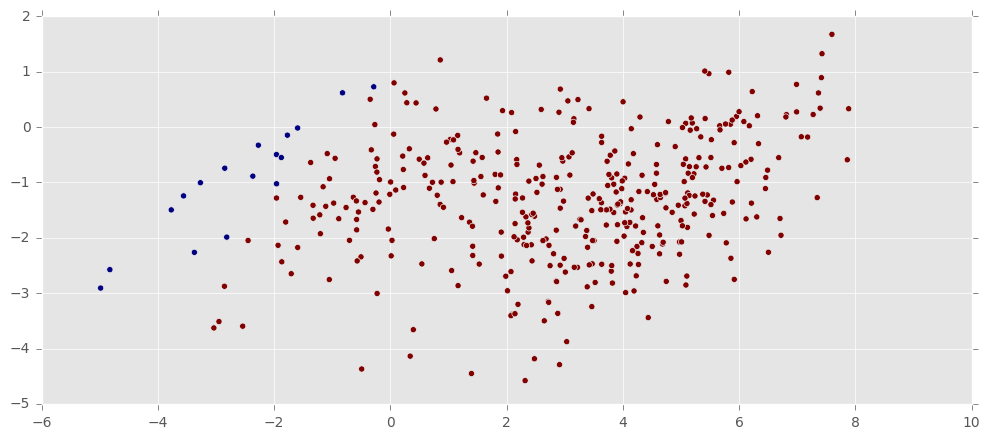

In [284]:
plt.scatter(X[:,0], X[:,1], c=predict)

In [135]:
import pandas
import math
from sklearn.metrics import roc_auc_score



In [387]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

In [354]:
w = np.zeros(X.shape[1])
w = np.array([100,100])

In [374]:
K = MySGDClassifier(C = 1, k = 0.01)
K_cl = K.fit(X, y)


0
0.0075
1
0.0148022756631
2
0.02191444483
3
0.0288442769845
4
0.0355995466931
5
0.042187916777
6
0.048616849456
7
0.0548935422718
8
0.0610248849643
9
0.067017433387
10
0.0728773968112
11
0.0786106354105
12
0.0842226652274
13
0.0897186684295
14
0.0951035071215
15
0.100381739377
16
0.105557636484
17
0.110635200658
18
0.115618182704
19
0.120510099238
20
0.125314249238
21
0.130033729763
22
0.134671450756
23
0.13923014888
24
0.143712400413
25
0.148120633182
26
0.152457137607
27
0.156724076882
28
0.160923496351
29
0.165057332128
30
0.169127419018
31
0.173135497799
32
0.1770832219
33
0.180972163543
34
0.184803819375
35
0.188579615647
36
0.192300912978
37
0.195969010728
38
0.199585151028
39
0.203150522487
40
0.206666263611
41
0.210133465956
42
0.213553177033
43
0.216926402996
44
0.220254111127
45
0.223537232131
46
0.226776662267
47
0.229973265318
48
0.233127874422
49
0.236241293771


In [388]:
X

array([[  5.10023581e+00,  -2.69111611e+00],
       [  7.86133980e+00,  -5.90275828e-01],
       [  3.03408318e+00,  -3.87586870e+00],
       [  4.27296419e+00,  -2.48115650e+00],
       [  5.11589775e+00,  -1.18894612e+00],
       [  6.68141026e+00,  -5.51816051e-01],
       [  4.68251252e+00,  -2.11149017e+00],
       [  5.00051149e+00,  -1.68815112e+00],
       [  4.19226260e+00,  -2.95938987e+00],
       [  3.21885639e+00,  -2.53373075e+00],
       [  5.48042789e+00,   9.65286729e-01],
       [  3.38675247e+00,  -2.88528098e+00],
       [  2.31845149e+00,  -4.57929624e+00],
       [  4.21922422e+00,  -1.78635389e+00],
       [  6.70403815e+00,  -1.65073636e+00],
       [  5.06724378e+00,  -1.42142792e+00],
       [  1.52880530e+00,  -2.47440858e+00],
       [  4.73452345e+00,  -1.19659111e+00],
       [  6.30356977e+00,  -1.62232867e+00],
       [  4.04654587e+00,  -1.53198075e+00],
       [  2.36997309e+00,  -1.89717198e+00],
       [  7.42616309e+00,   1.32563647e+00],
       [  

In [375]:
predict = K.predict_proba(X)

In [376]:
predict

array([ 0.95072175,  0.96970767,  0.92240171,  0.92953859,  0.92805003,
        0.95234609,  0.93332568,  0.93388134,  0.93573049,  0.89865612,
        0.8921864 ,  0.9124232 ,  0.91586439,  0.91447856,  0.9645252 ,
        0.93095015,  0.81852785,  0.91760919,  0.95846241,  0.90317007,
        0.84260647,  0.94130318,  0.89626246,  0.91996529,  0.88068268,
        0.9149741 ,  0.86794277,  0.92956154,  0.92786032,  0.89631648,
        0.8956521 ,  0.83428454,  0.91046176,  0.90412518,  0.90466047,
        0.93305977,  0.90222234,  0.90586015,  0.88349553,  0.91539399,
        0.92458483,  0.87702969,  0.96923307,  0.93206764,  0.92978633,
        0.94216264,  0.94444363,  0.94081409,  0.95639116,  0.93112123,
        0.91233698,  0.92474515,  0.94726513,  0.88729818,  0.96744881,
        0.95962817,  0.94997195,  0.9349557 ,  0.92941001,  0.94792075,
        0.89147641,  0.95173004,  0.90222983,  0.95321257,  0.93847274,
        0.92124079,  0.90833108,  0.92683023,  0.92253997,  0.89

## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

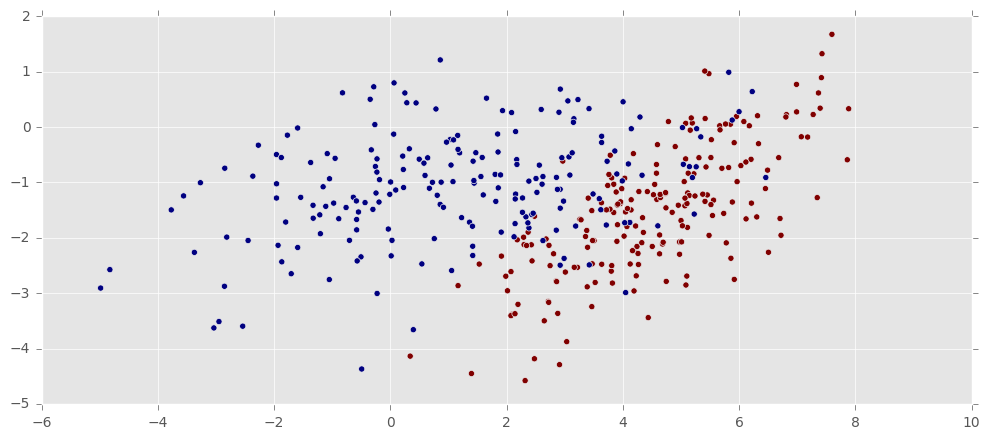

In [269]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

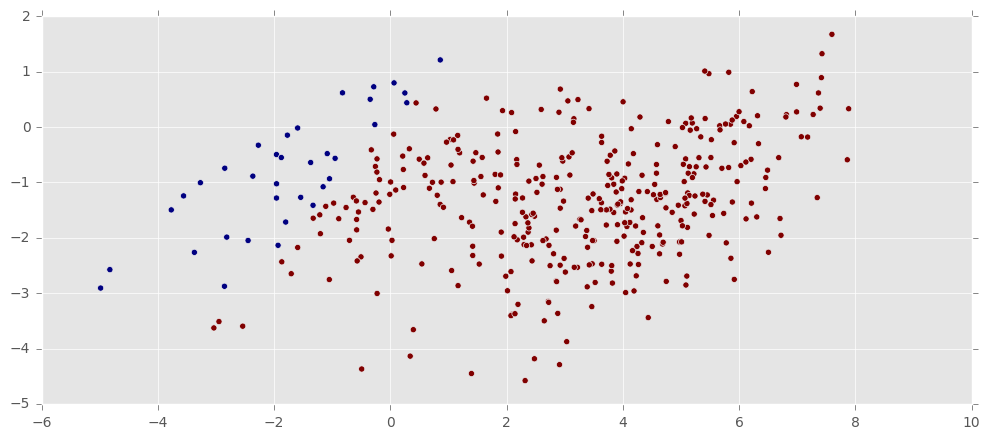

In [270]:
plt.scatter(X[:,0], X[:,1], c=predict)

## Анализ сходимости (2 балл)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

In [ ]:
## Your Code Here

# Введение в конкурсную задачу

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

### Правила
* Объединяться в команды по правилам конкурса можно, но по правилам нашего курса - нельзя)
* Вы можете использовать любой алгоритм, даже неизученный в нашем курсе (если на защите сможете объяснить как он работает)
* Имейте ввиду, что вы должны отправить результаты строго до 14 мая 23:59 GMT на сайт соревнования (раздел submission). Без результата в leaderboard оценка выставлена не будет.

## Данные

Для того, чтобы получить данные необходимо зарегистрироваться на сайте соревнования. 

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


Данные поставляются в двух форматах:
* В формате json содержится полная информация по текущему состоянию раунда
* В табличном формате упрощенная аггрерированная информация по текущему состоянию раунда

В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если данные не будут помещаться вам с оперативную память, рекомендуется совершить предобработку в python, а  моделирование выполнять с помощью [vowpal wabbit](https://github.com/JohnLangford/vowpal_wabbit).

In [398]:
# Загрузка данных целиком
#df_list = []
#for chunk in range(1,5):
#    filepath = './trainingData_tabular_chunk%d.csv' % chunk
#    df_list.append(pd.read_csv(filepath, sep=','))

#df_data = pd.concat(df_list)

# Загрузка одной части данных
df_data = pd.read_csv('trainingData_tabular_chunk1.csv', sep=',')

In [292]:
df_data.shape

(500000, 45)

In [399]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [296]:
df_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [400]:
df_data = df_data.reset_index('gamestate_id')
df_data

,gamestate_id,decision,turn,opponent_armor,opponent_attack,opponent_hero_card_id,opponent_hp,opponent_special_skill_used,opponent_weapon_durability,opponent_crystals_all,...,player_played_hp_current,player_played_hp_max,player_hand_nOfMinions,player_hand_nOfSpells,player_hand_nOfWeapons,player_hand_nOfCards,player_hand_nOfPlayable,player_hand_attack,player_hand_crystals_cost,player_hand_hp
0,4687346,1,14,0,0,798,5,0,0,10,...,20,23,4,0,1,5,0,20,22,17
1,3270826,1,7,0,0,754,22,0,0,6,...,16,17,3,2,2,7,0,17,26,20
2,3189487,1,5,3,0,612,29,0,0,4,...,0,0,5,0,0,5,2,26,28,27
3,4098946,1,8,0,0,390,26,0,0,7,...,2,2,7,1,1,9,9,36,44,36
4,2661127,0,13,0,0,25,30,0,0,10,...,7,7,4,0,0,4,4,13,13,14
5,2993360,0,13,0,0,612,26,0,0,10,...,9,9,5,0,0,5,0,19,25,25
6,4378268,0,9,0,0,612,20,0,0,9,...,8,8,5,1,0,6,6,23,30,23
7,3774658,1,2,0,0,390,30,0,0,1,...,0,0,4,1,0,5,1,22,25,25
8,3956442,1,12,2,0,1235,18,0,0,10,...,2,6,2,1,1,4,4,12,15,10
9,2958739,1,10,0,0,1235,16,0,0,9,...,18,19,2,0,0,2,0,5,7,6


In [401]:
df_data = df_data.loc[:1999, :]
y = df_data.loc[:2000, 'decision']

y

0       1
1       1
2       1
3       1
4       0
5       0
6       0
7       1
8       1
9       1
10      1
11      1
12      1
13      0
14      0
15      0
16      0
17      0
18      0
19      1
20      0
21      0
22      1
23      0
24      1
25      1
26      1
27      1
28      1
29      1
       ..
1970    1
1971    0
1972    0
1973    0
1974    0
1975    0
1976    0
1977    1
1978    0
1979    0
1980    0
1981    1
1982    0
1983    1
1984    1
1985    1
1986    1
1987    0
1988    1
1989    1
1990    0
1991    0
1992    1
1993    0
1994    1
1995    0
1996    1
1997    0
1998    0
1999    0
Name: decision, dtype: int64

In [402]:
df_data = df_data.set_index('gamestate_id')

In [332]:
df_data

,decision,turn,opponent_armor,opponent_attack,opponent_hero_card_id,opponent_hp,opponent_special_skill_used,opponent_weapon_durability,opponent_crystals_all,opponent_crystals_current,...,player_played_hp_current,player_played_hp_max,player_hand_nOfMinions,player_hand_nOfSpells,player_hand_nOfWeapons,player_hand_nOfCards,player_hand_nOfPlayable,player_hand_attack,player_hand_crystals_cost,player_hand_hp
gamestate_id,,,,,,,,,,,,,,,,,,,,,
4687346,1,14,0,0,798,5,0,0,10,10,...,20,23,4,0,1,5,0,20,22,17
3270826,1,7,0,0,754,22,0,0,6,6,...,16,17,3,2,2,7,0,17,26,20
3189487,1,5,3,0,612,29,0,0,4,1,...,0,0,5,0,0,5,2,26,28,27
4098946,1,8,0,0,390,26,0,0,7,7,...,2,2,7,1,1,9,9,36,44,36
2661127,0,13,0,0,25,30,0,0,10,1,...,7,7,4,0,0,4,4,13,13,14
2993360,0,13,0,0,612,26,0,0,10,3,...,9,9,5,0,0,5,0,19,25,25
4378268,0,9,0,0,612,20,0,0,9,2,...,8,8,5,1,0,6,6,23,30,23
3774658,1,2,0,0,390,30,0,0,1,1,...,0,0,4,1,0,5,1,22,25,25
3956442,1,12,2,0,1235,18,0,0,10,2,...,2,6,2,1,1,4,4,12,15,10


In [333]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.504

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощьб one-hot кодирования, добавьте к датасету и удалите прежние столбцы

In [ ]:
## Youd Code Here

## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Обучите модуль из первой части этого ДЗ на данных

In [403]:
## Youd Code Here
#df_data = df_data.values
del df_data['decision']
df_data = df_data.values

In [404]:
K = MySGDClassifier(C = 1, k = 0.1)
K_cl = K.fit(df_data, y)

0
0.0745
1
0.11605
2
0.153445
3
0.1871005
4
0.21739045
5
0.244651405
6
0.2691862645
7
0.29126763805
8
0.311140874245
9
0.32902678682
10
0.345124108138
11
0.359611697325
12
0.372650527592
13
0.384385474833
14
0.39494692735
15
0.404452234615
16
0.413007011153
17
0.420706310038
18
0.427635679034
19
0.433872111131
20
0.439484900018
21
0.444536410016
22
0.449082769014
23
0.453174492113
24
0.456857042902
25
0.460171338611
26
0.46315420475
27
0.465838784275
28
0.468254905848
29
0.470429415263
30
0.472386473737
31
0.474147826363
32
0.475733043727
33
0.477159739354
34
0.478443765419
35
0.479599388877
36
0.480639449989
37
0.48157550499
38
0.482417954491
39
0.483176159042
40
0.483858543138
41
0.484472688824
42
0.485025419942
43
0.485522877947
44
0.485970590153
45
0.486373531137
46
0.486736178024
47
0.487062560221
48
0.487356304199
49
0.487620673779


## Применение модели (3 балла)
#### Задание
* Загрузите тестовые данные
* Выполните те же операции с датасетом, что и с обучающей выборкой
* Примените модель и загрузите решение на страницу конкурса
* Напечатайте ваш ник и оценку качества, полученную после загрузки

Судя по описанию, submission file должен состоять из одного столбца с числами, соответствующим вероятностям победы игрока.

In [405]:
## Youd Code Here
df_data_test = pd.read_csv('testData_tabular.csv', sep=',')
df_data_test.columns = df_data_test.columns.str.replace('.', '_')
df_data_test = df_data_test.set_index('gamestate_id')

In [406]:
#del df_data_test['decision']
df_data_test = df_data_test.values

In [397]:
predict = K.predict_proba(df_data_test)


750000.0

In [413]:
np.savetxt('test.out', predict, delimiter=',') 

In [412]:
final.to_csv('solution.csv', index = False)